<a href="https://colab.research.google.com/github/Rezckant/practice/blob/main/SMS_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -N https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -N https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

--2022-04-25 22:50:09--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘train-data.tsv’ not modified on server. Omitting download.

--2022-04-25 22:50:09--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘valid-data.tsv’ not modified on server. Omitting download.



In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
tfds.disable_progress_bar()

In [ ]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [ ]:
train_df.head()


,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [ ]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [ ]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [ ]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [ ]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 157s 3s/step - loss: 0.6694 - accuracy: 0.8657 - val_loss: 0.6367 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 131s 3s/step - loss: 0.5796 - accuracy: 0.8657 - val_loss: 0.5292 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 131s 3s/step - loss: 0.4894 - accuracy: 0.8657 - val_loss: 0.4619 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 133s 3s/step - loss: 0.4181 - accuracy: 0.8657 - val_loss: 0.3808 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 132s 3s/step - loss: 0.3177 - accuracy: 0.8657 - val_loss: 0.2473 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 134s 3s/step - loss: 0.1980 - accuracy: 0.8657 - val_loss: 0.1595 - val_accuracy: 0.8604
Epoch 7/10
44/44 [==============================] - 131s 3s/step - loss: 0.1347 - accuracy: 0.8736 - val_loss: 0.1161 - val_accuracy: 0.9219
Epoch 8/10
44

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

44/44 [==============================] - 22s 501ms/step - loss: 0.0439 - accuracy: 0.9899
Test Loss: 0.04385574534535408
Test Accuracy: 0.9899425506591797


In [ ]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.7004409603774547)

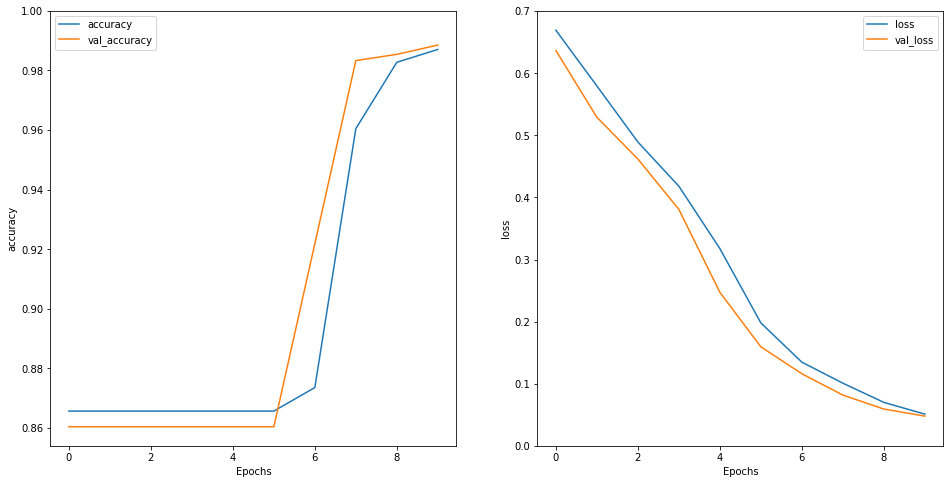

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6693636775016785, 0.5795827507972717, 0.4893806278705597, 0.4181194603443146, 0.3176840543746948, 0.1979680061340332, 0.13473230600357056, 0.10089083760976791, 0.06995502859354019, 0.051024794578552246]
[0.6366888880729675, 0.5292004942893982, 0.46194157004356384, 0.3808411657810211, 0.24726241827011108, 0.15947729349136353, 0.11609645932912827, 0.08169162273406982, 0.05923311039805412, 0.04781801998615265]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8735632300376892, 0.960488498210907, 0.982758641242981, 0.9870689511299133]
[0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.921875, 0.9833333492279053, 0.9854166507720947, 0.9885416626930237]


In [ ]:
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[[-5.1671085]]
[-5.1671085, 'ham']


In [ ]:
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

[[-5.1671085]]
[[0.21127698]]
[[-12.264897]]
[[1.3222697]]
[[1.4297229]]
[[-9.663691]]
[[-10.586938]]
You haven't passed yet. Keep trying.
